# 📝 A Comparative Analysis of Forecasting Models for Macroeconomic Time Series

The first half of this notebook contains loading, cleaning, and performing Exploratory Data Analysis (EDA) on the 12 macroeconomic time series from the Federal Reserve Economic Data (FRED) website.

The second half contains the analysis of multiple models of which Times FM performed the best.

Import Necessary Libraries:

First, we'll import the libraries we need for data manipulation (pandas) and plotting (matplotlib, seaborn).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


Load and Consolidate All CSV Files:

This block will find all the CSV files in your directory, load them, and merge them into a single master DataFrame using the DATE column.

In [ ]:
#Create a list of all CSV files in the current directory
all_files = [f for f in os.listdir('.') if f.endswith('.csv')]

#Use the first file to initialize our master DataFrame
master_df = pd.read_csv(all_files[0])
master_df['observation_date'] = pd.to_datetime(master_df['observation_date'])

#Loop through the rest of the files and merge them
for file in all_files[1:]:
    temp_df = pd.read_csv(file)
    temp_df['observation_date'] = pd.to_datetime(temp_df['observation_date'])
    master_df = pd.merge(master_df, temp_df, on='observation_date', how='outer')

print("All 12 CSV files have been merged into a single DataFrame.")
print("Shape of the raw merged data:", master_df.shape)
master_df.head()

All 12 CSV files have been merged into a single DataFrame.
Shape of the raw merged data: (1352, 13)


,observation_date,UMCSENT,TOTALSA,PCE,PAYEMS,CPIAUCSL,AUINSA,PSAVERT,FEDFUNDS,UNRATE,IPG3361T3S,GDP,PPIACO
0,1913-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.1
1,1913-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
2,1913-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
3,1913-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
4,1913-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.9


Clean and Prepare the Data:

This is the most critical preparation step. We will handle the uneven start dates, fill in missing monthly values for quarterly data like GDP, and rename the columns to be more readable.

In [ ]:
#Set the correct date column as the index before cleaning
master_df = master_df.set_index('observation_date').sort_index()

#Truncate the DataFrame to the latest common start date
start_dates = master_df.apply(pd.Series.first_valid_index)
latest_start_date = start_dates.max()
clean_df = master_df.loc[latest_start_date:]

#Forward-fill to handle quarterly data and any other gaps
clean_df = clean_df.ffill()

#Drop any remaining rows with missing data (a final safety check)
clean_df = clean_df.dropna()

#Rename columns from FRED IDs to human-readable names
column_renames = {
    'CPIAUCSL': 'Inflation_CPI',
    'UNRATE': 'Unemployment_Rate',
    'GDP': 'GDP',
    'PAYEMS': 'Nonfarm_Payrolls',
    'PPIACO': 'Producer_Price_Index',
    'FEDFUNDS': 'Federal_Funds_Rate',
    'UMCSENT': 'Consumer_Sentiment',
    'PCE': 'Personal_Consumption',
    'PSAVERT': 'Personal_Saving_Rate',
    'TOTALSA': 'Total_Vehicle_Sales',
    'IPG3611T3S': 'Auto_Industrial_Production',
    'AUINSA': 'Auto_Inventories'}
clean_df = clean_df.rename(columns=column_renames)

print(f"Data cleaned. The dataset now starts on {clean_df.index.min().date()}.")
print("\nDataFrame Info:")
clean_df.info()

Data cleaned. The dataset now starts on 1993-01-01.

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 392 entries, 1993-01-01 to 2025-08-01
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Consumer_Sentiment    392 non-null    float64
 1   Total_Vehicle_Sales   392 non-null    float64
 2   Personal_Consumption  392 non-null    float64
 3   Nonfarm_Payrolls      392 non-null    float64
 4   Inflation_CPI         392 non-null    float64
 5   Auto_Inventories      392 non-null    float64
 6   Personal_Saving_Rate  392 non-null    float64
 7   Federal_Funds_Rate    392 non-null    float64
 8   Unemployment_Rate     392 non-null    float64
 9   IPG3361T3S            392 non-null    float64
 10  GDP                   392 non-null    float64
 11  Producer_Price_Index  392 non-null    float64
dtypes: float64(12)
memory usage: 39.8 KB


## 📊 Exploratory Data Analysis (EDA)
Now that we have a clean dataset, let's explore it to understand its characteristics.

Summary Statistics:

Let's start by getting a high-level statistical summary of each indicator.

In [ ]:
clean_df.describe()

,Consumer_Sentiment,Total_Vehicle_Sales,Personal_Consumption,Nonfarm_Payrolls,Inflation_CPI,Auto_Inventories,Personal_Saving_Rate,Federal_Funds_Rate,Unemployment_Rate,IPG3361T3S,GDP,Producer_Price_Index
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,85.297704,15.905094,10541.412755,135915.005102,215.935791,995.203171,5.800765,2.602628,5.596939,84.410324,15659.036997,175.926758
std,13.914647,2.004887,4346.472842,11813.994047,47.674156,415.659767,2.875494,2.202881,1.780109,15.968922,6303.085238,43.208042
min,50.000000,8.944000,4340.700000,109790.000000,142.800000,74.683000,1.400000,0.050000,3.400000,20.412800,6729.459000,118.000000
25%,74.300000,14.996750,7000.525000,130396.750000,176.075000,773.990250,4.500000,0.180000,4.300000,72.597000,10470.231000,131.425000
50%,88.400000,16.347500,10034.700000,134319.000000,216.185000,1110.614000,5.600000,2.065000,5.150000,85.911050,14715.058000,181.150000
75%,95.525000,17.305250,13185.225000,144314.500000,244.205500,1278.325000,6.500000,5.030000,6.125000,98.934275,19502.131000,201.825000
max,112.000000,22.055000,20802.000000,159540.000000,323.364000,1728.500000,32.000000,6.540000,14.800000,111.632100,30353.902000,280.251000


Plot Each Time Series Individually:

This is the best way to see the trends, seasonality, and major events (like recessions) for each indicator.

Plotting each economic indicator over time...


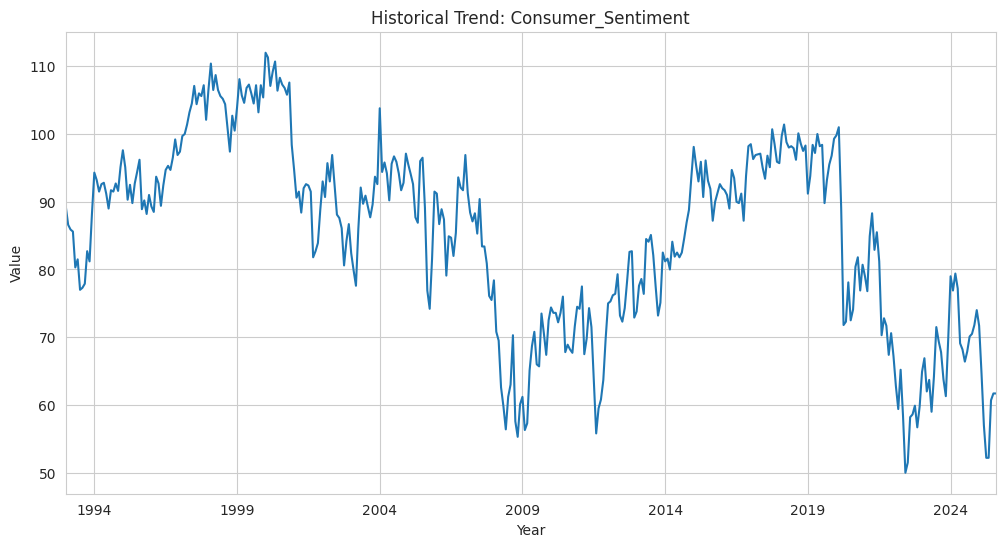

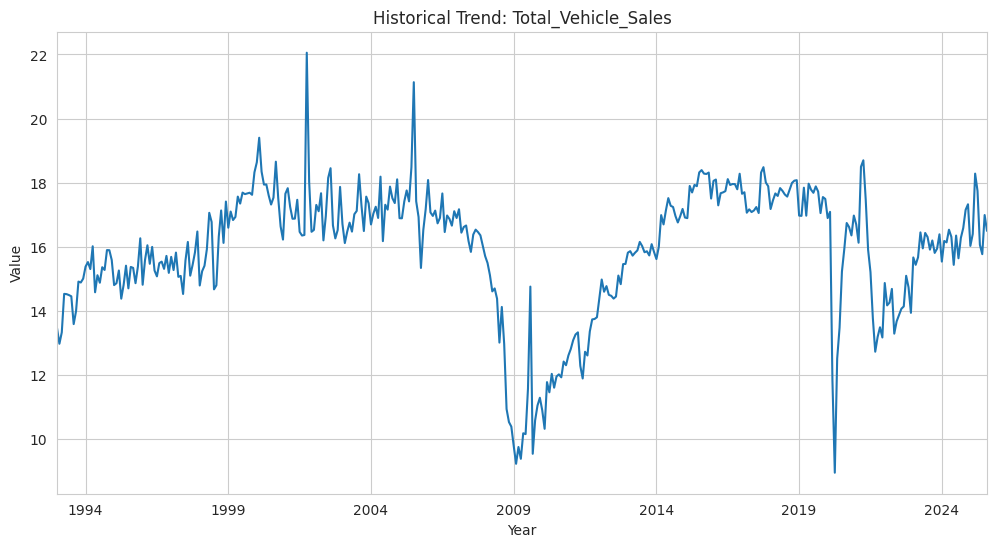

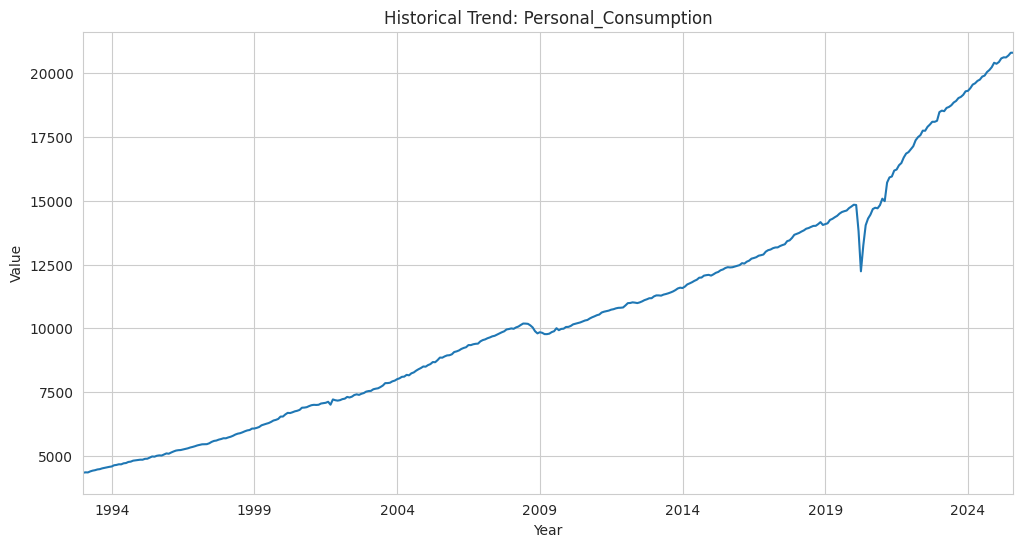

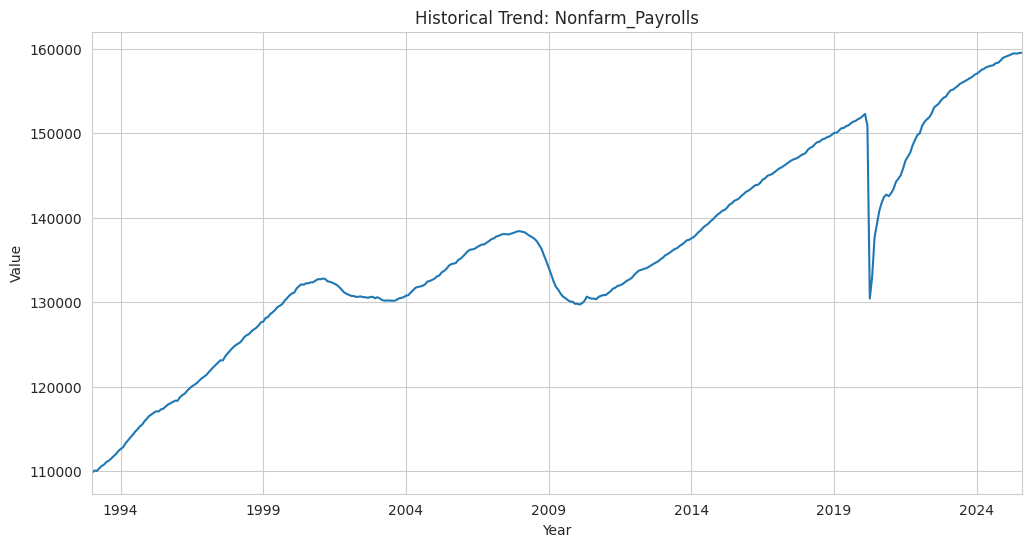

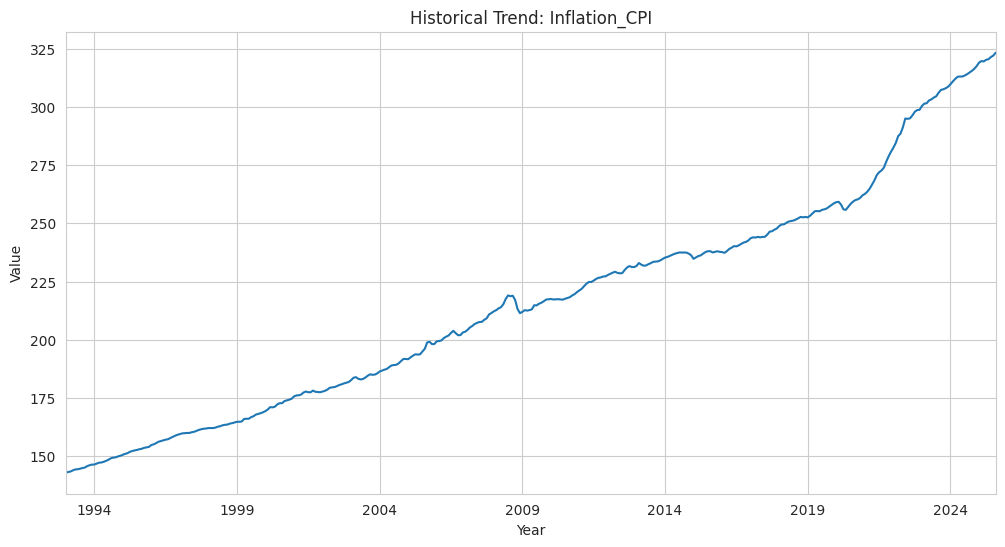

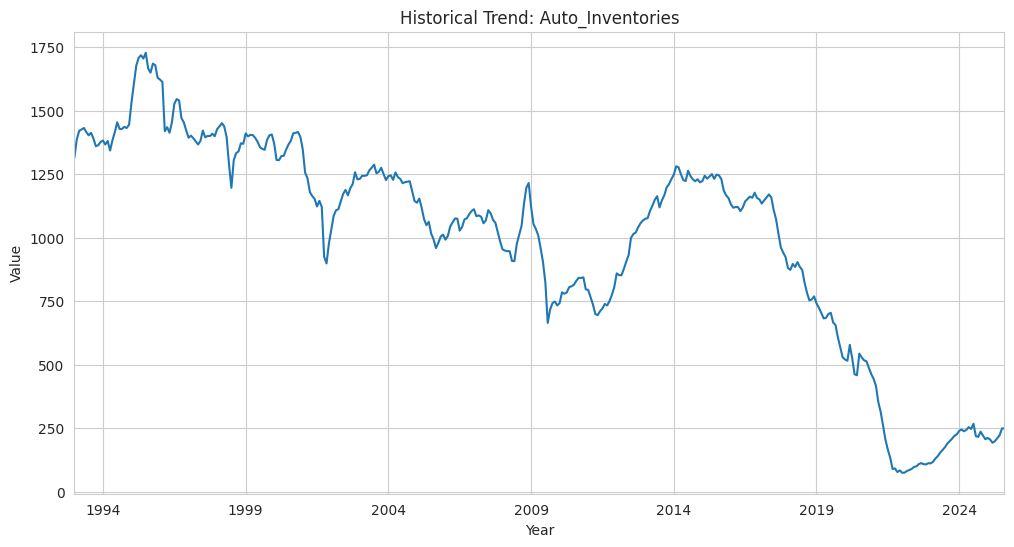

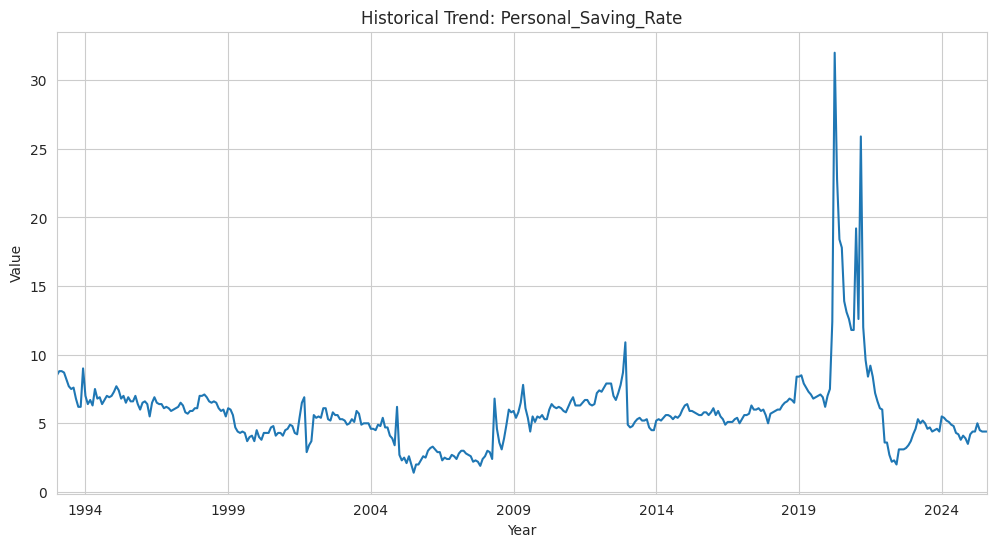

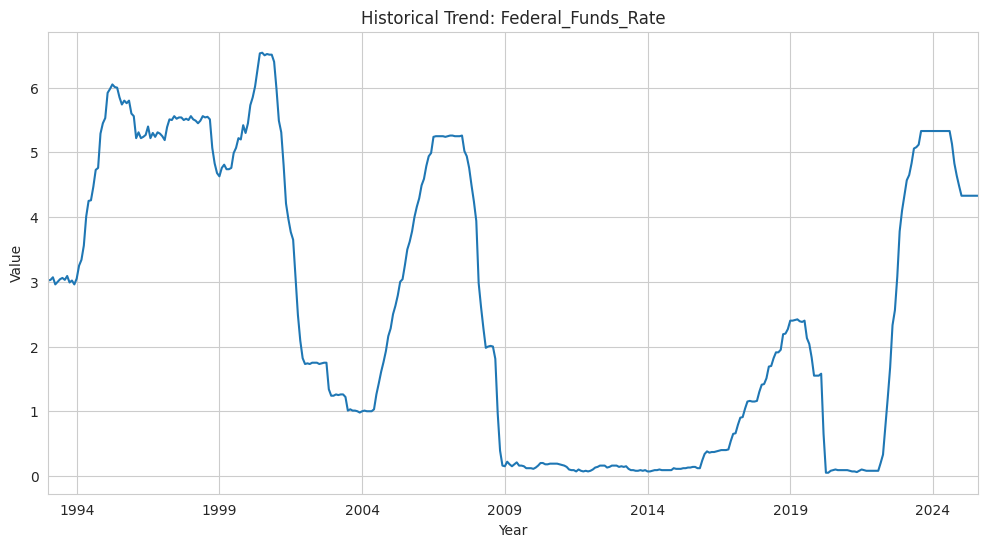

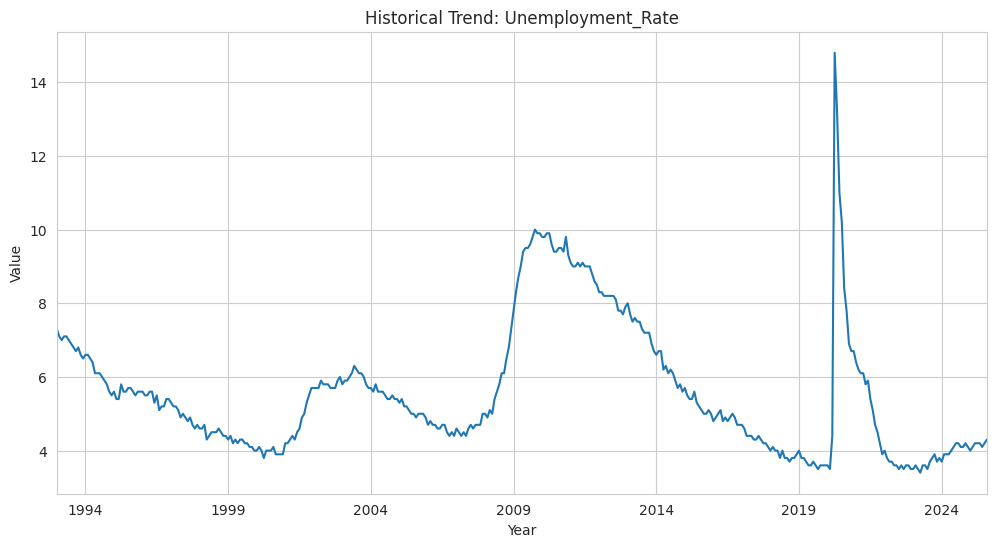

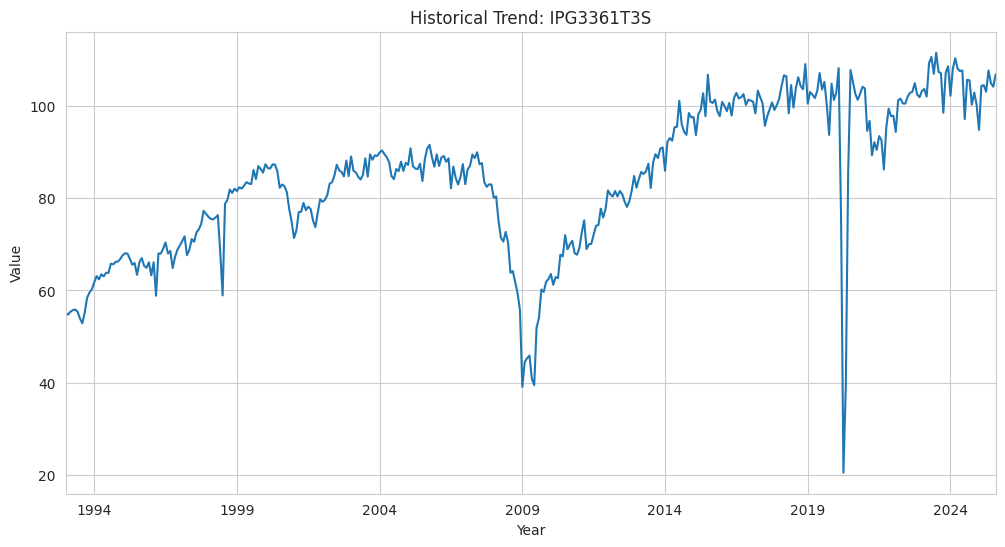

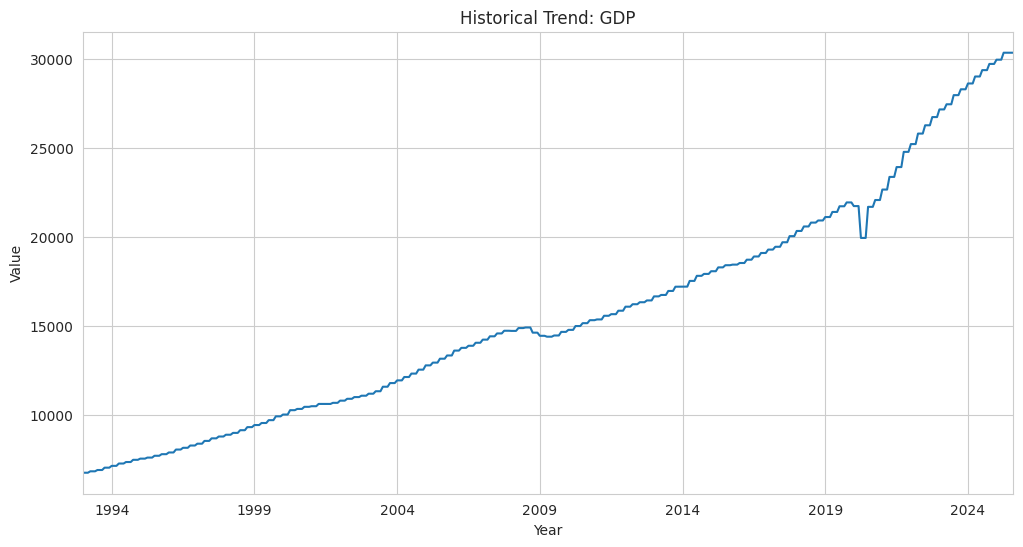

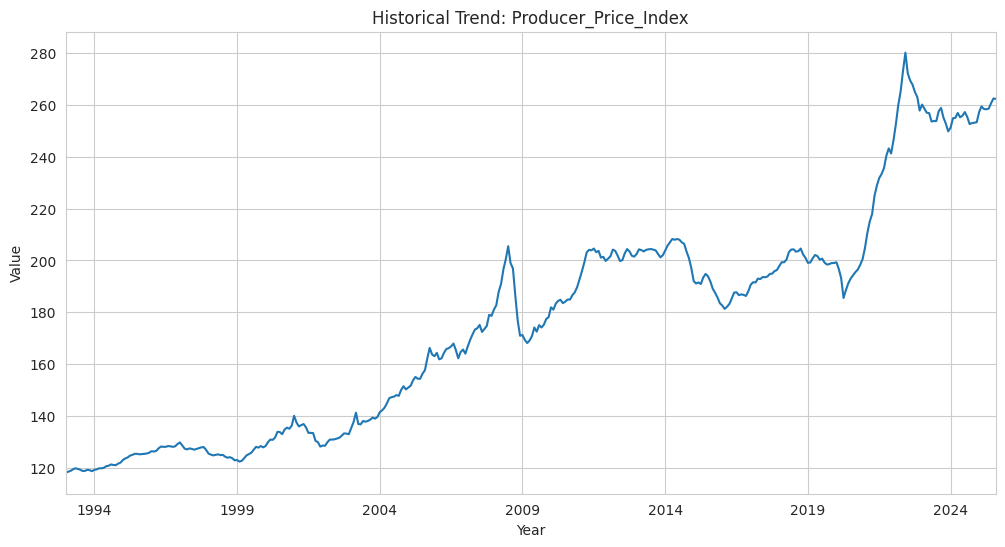

In [ ]:
print("Plotting each economic indicator over time...")

for column in clean_df.columns:
    plt.figure(figsize=(12, 6))
    clean_df[column].plot(title=f'Historical Trend: {column}')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.show()

### Visualize a Correlation Heatmap:

A heatmap helps us understand the relationships between the different indicators.

Red squares mean the two indicators tend to move together (e.g., GDP and Payrolls).

Blue squares mean they move in opposite directions (e.g., Unemployment and GDP).

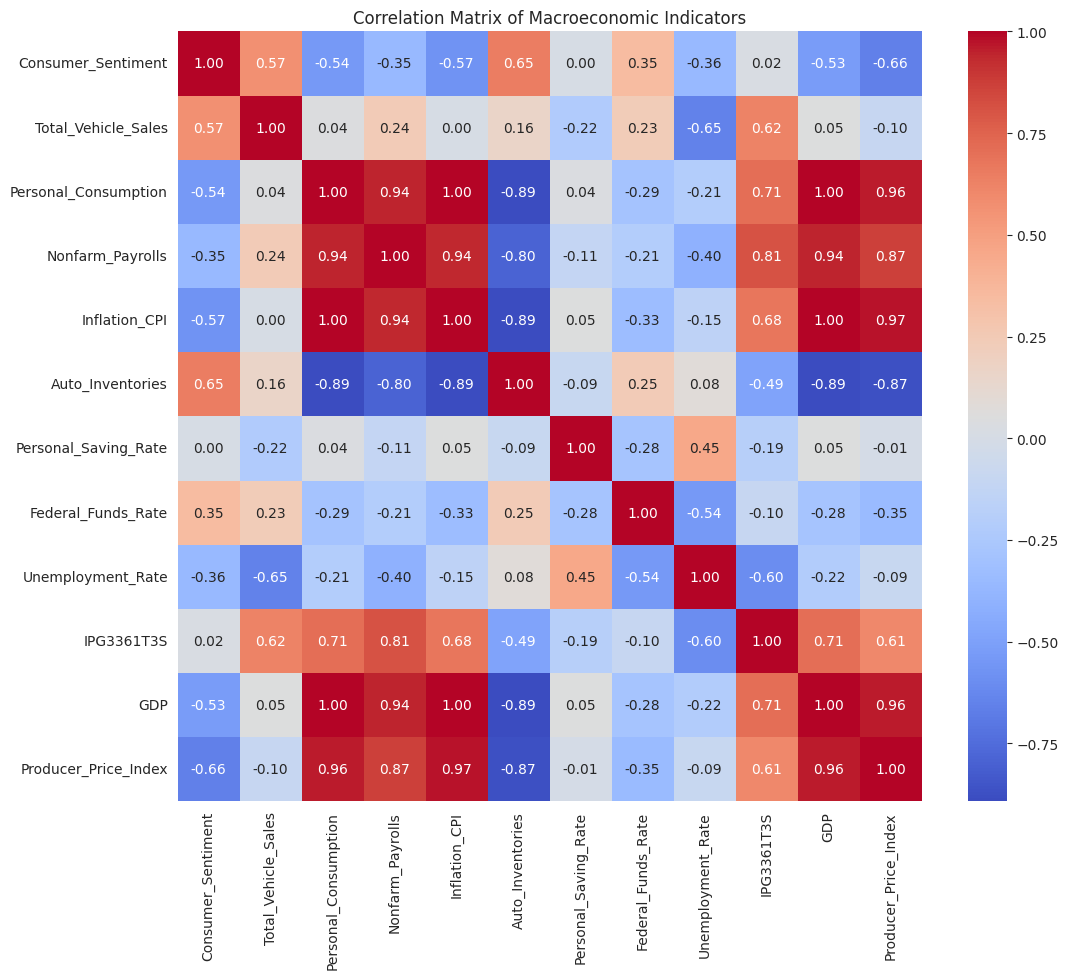

In [ ]:
plt.figure(figsize=(12, 10))
correlation_matrix = clean_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Macroeconomic Indicators')
plt.show()

**ANALYSIS:-**

The correlation matrix shows interesting relationships, and the individual time series plots (like for Inflation and Unemployment) clearly show non-stationary behavior (i.e., they have trends).

This heatmap provides a quick, powerful overview of how the different economic variables move in relation to one another.

- **Key Inference 1 (Strong Positive Correlation):** We can see strong positive relationships (deep red squares) that align with economic theory. For example, GDP and Nonfarm Payrolls have a correlation of 0.94, confirming that economic growth is tightly linked to job creation. Similarly, Inflation (CPI) and the Producer Price Index are almost perfectly correlated (0.97), indicating that costs for producers are passed on to consumers.

- **Key Inference 2 (Strong Negative Correlation):** The map highlights expected inverse relationships (deep blue squares). Auto Inventories and Total Vehicle Sales have a strong negative correlation of -0.89, which makes sense: as more cars are sold, the number of unsold cars in inventory decreases.

- **Key Inference 3 (Identifying Leading Indicators):** Weaker correlations can suggest "leading" relationships that we'll explore later with lag analysis. For instance, the Federal Funds Rate has a negative correlation with Total Vehicle Sales (-0.21) and GDP (-0.22), hinting that changes in interest rates may precede changes in sales and economic growth.

NOTE:-

We chose Inflation_CPI as our representative sample because its trend was very clear. The detailed analysis (detrending, differencing, ACF plots) on this one series allowed us to diagnose the core, underlying condition of our dataset: non-stationarity.

###Analyze Trends with Rolling Averages:

Plotting a rolling average helps smooth out short-term noise and highlights the long-term trend. Let's do this for a couple of key indicators.

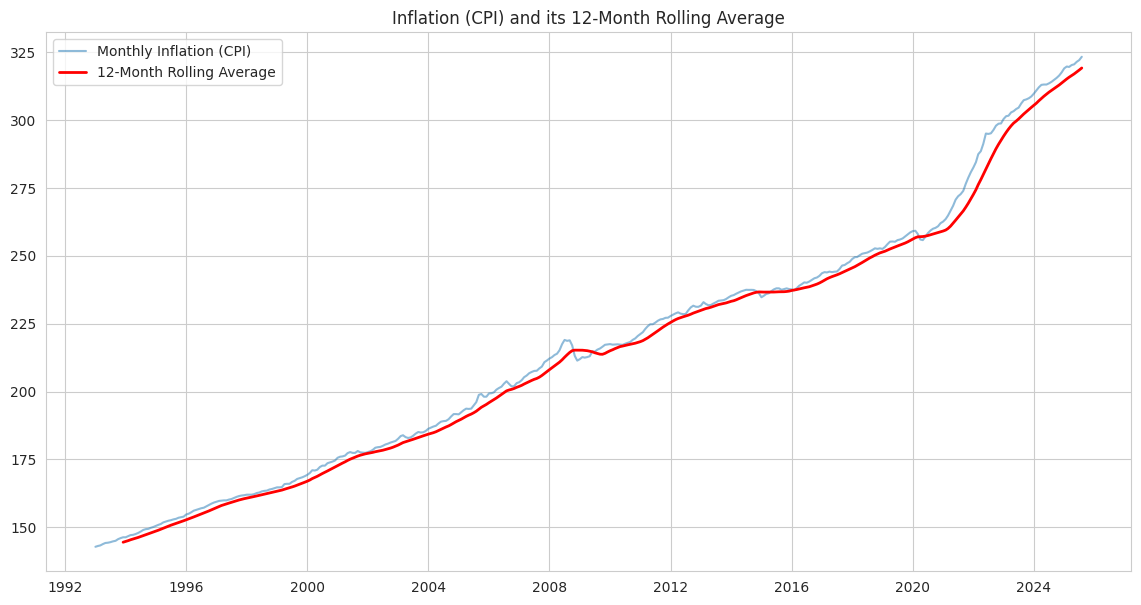

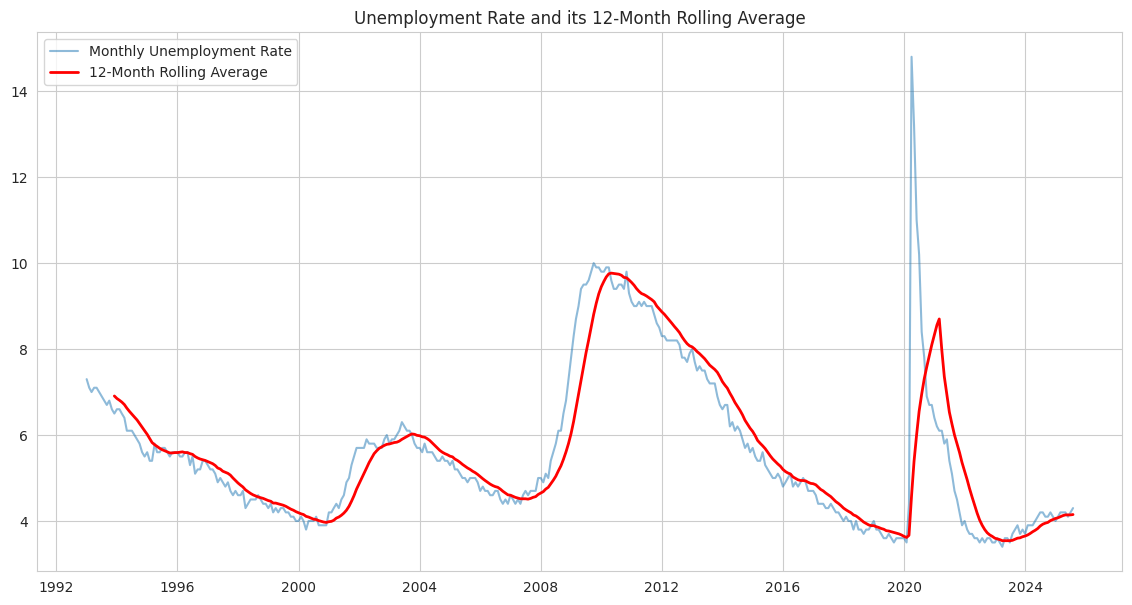

In [ ]:
#Calculate the 12-month rolling average
clean_df['Inflation_CPI_12M_Rolling'] = clean_df['Inflation_CPI'].rolling(window=12).mean()
clean_df['Unemployment_Rate_12M_Rolling'] = clean_df['Unemployment_Rate'].rolling(window=12).mean()

#Plot Inflation vs. its rolling average
plt.figure(figsize=(14, 7))
plt.plot(clean_df.index, clean_df['Inflation_CPI'], label='Monthly Inflation (CPI)', alpha=0.5)
plt.plot(clean_df.index, clean_df['Inflation_CPI_12M_Rolling'], label='12-Month Rolling Average', color='red', linewidth=2)
plt.title('Inflation (CPI) and its 12-Month Rolling Average')
plt.legend()
plt.show()

#Plot Unemployment vs. its rolling average
plt.figure(figsize=(14, 7))
plt.plot(clean_df.index, clean_df['Unemployment_Rate'], label='Monthly Unemployment Rate', alpha=0.5)
plt.plot(clean_df.index, clean_df['Unemployment_Rate_12M_Rolling'], label='12-Month Rolling Average', color='red', linewidth=2)
plt.title('Unemployment Rate and its 12-Month Rolling Average')
plt.legend()
plt.show()

##Inflation (CPI) and its 12-Month Rolling Average
This plot visualizes the behavior of inflation over time.

- **Key Inference 1 (Non-Stationary Trend):** The most prominent feature is the clear, long-term upward trend. This visually confirms that the inflation series is non-stationary, meaning its statistical properties (like the mean) change over time. This was the primary motivation for performing the detrending and differencing in our more advanced EDA.

- **Key Inference 2 (Identifying Economic Regimes):** The smoothed, 12-month rolling average (red line) makes it easy to identify different periods. We can clearly see a phase of relatively stable, low inflation throughout the 2010s, followed by a dramatic and sustained increase beginning around 2021.

##Unemployment Rate and its 12-Month Rolling Average
This plot reveals the cyclical nature of the labor market.

- **Key Inference 1 (Strong Cyclicality):** Unlike the steady trend of inflation, the unemployment rate is highly cyclical. It rises sharply and quickly during economic downturns and declines slowly and gradually during periods of expansion.

- **Key Inference 2 (Clear Recession Signals):** The plot serves as a historical map of recent recessions. The distinct peaks in the unemployment rate clearly correspond to major economic shocks: the aftermath of the dot-com bubble (~2003), the Great Financial Crisis (~2009), and the unprecedented spike from the COVID-19 pandemic (2020).

- **Key Inference 3 ("Stickiness"):** The rolling average (red line) highlights how "sticky" unemployment is; after a sharp increase, it takes several years for the rate to return to its pre-recession levels.

##Advanced EDA: Stationarity and Autocorrelation

Analyzing and Removing Trends:

- According to Time Series analysis practices, stationarity has to be insured before any trend analysis is to be performed.

Two primary methods to handle trends and make a series stationary:

Detrending via regression and differencing. Let's apply both to the Inflation_CPI series, which has a clear upward trend, similar to the "Chicken Prices" example in Schumway and Stoffer.

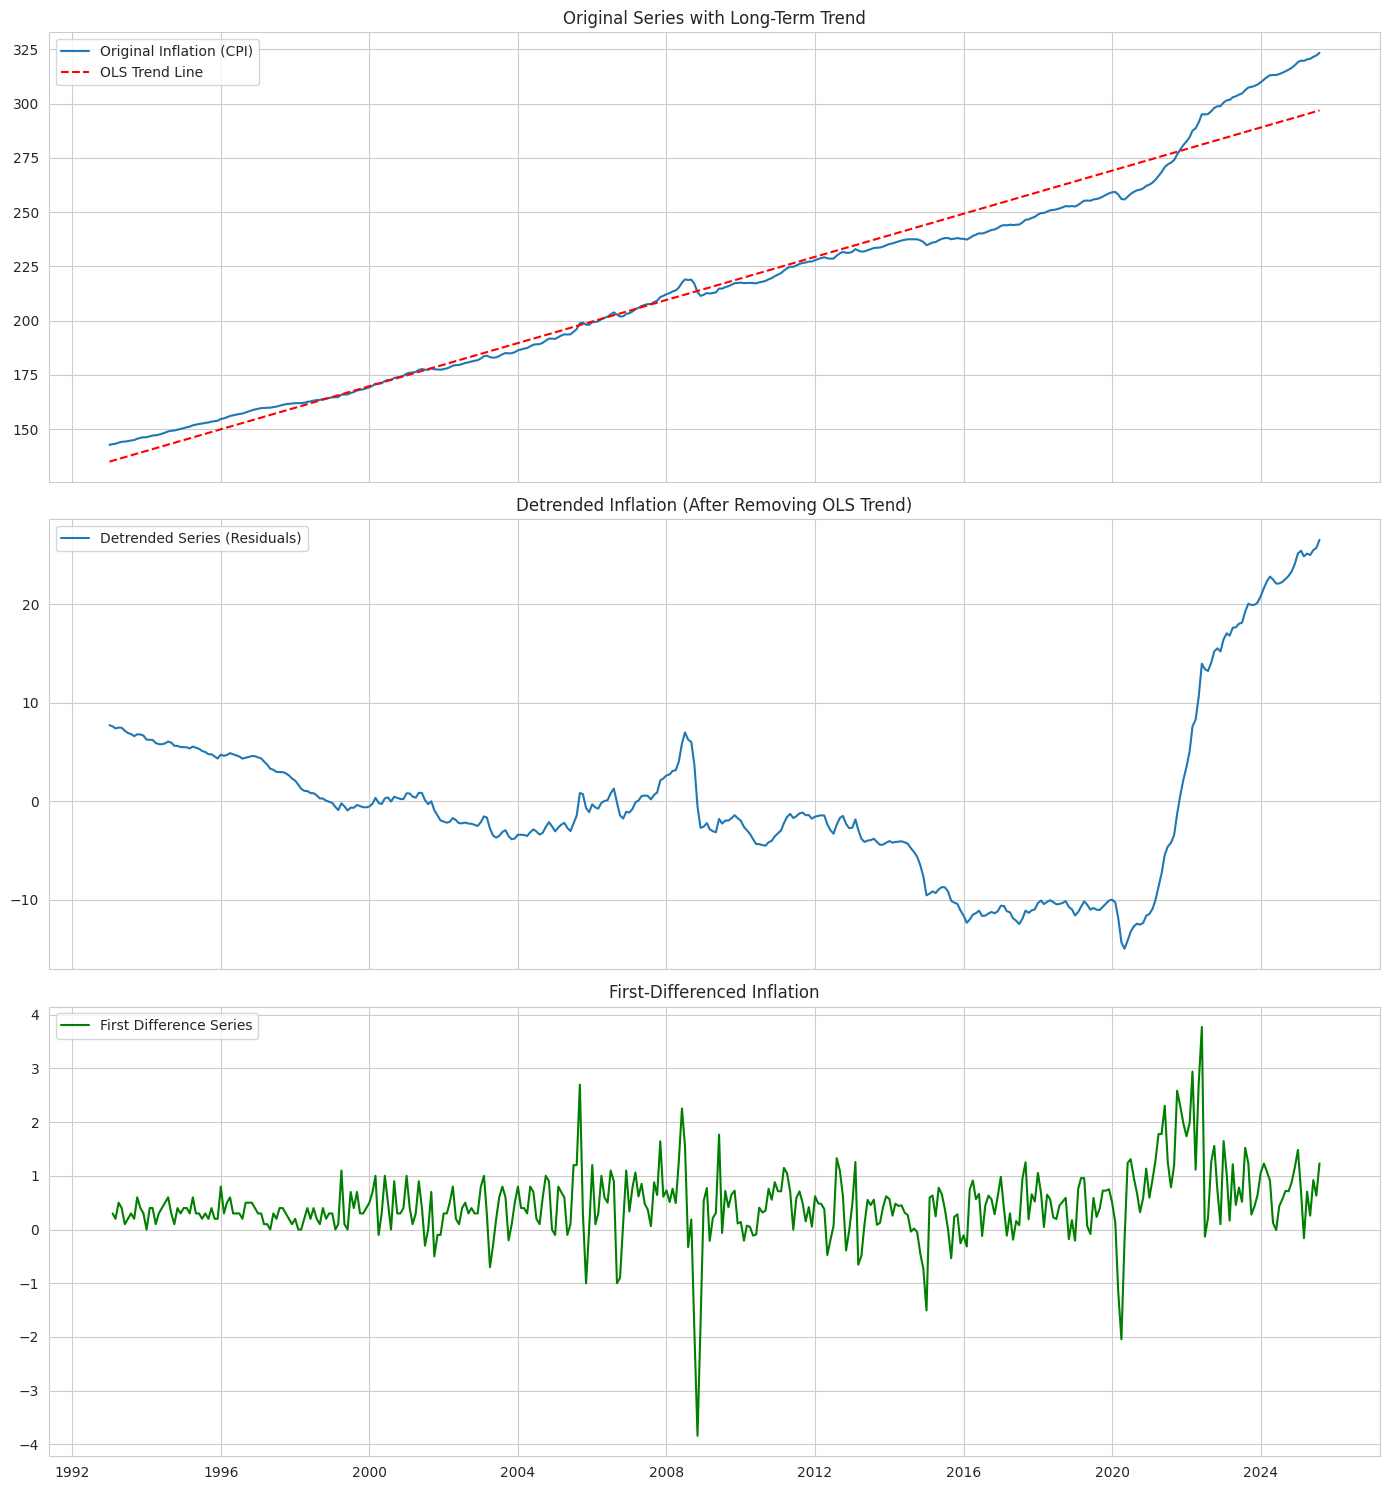

In [ ]:
import statsmodels.api as sm
import numpy as np

###Detrending using Ordinary Least Squares (OLS)

#This mimics the chicken price example

#Prepare the data for regression
y=clean_df['Inflation_CPI']
X= np.arange(len(y))
X= sm.add_constant(X) #intercept

#Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

#Create the trend line
trend= results.predict(X)

#Calculate the detrended series (the residuals)
detrended_series = results.resid

###Achieving Stationarity using Differencing

differenced_series = clean_df['Inflation_CPI'].diff().dropna()


#Plotting the Results
fig, axes = plt.subplots(3, 1, figsize=(14, 15), sharex=True)

#Plot 1: Original Series with OLS Trend
axes[0].plot(clean_df.index, clean_df['Inflation_CPI'], label='Original Inflation (CPI)')
axes[0].plot(clean_df.index, trend, label='OLS Trend Line', color='red', linestyle='--')
axes[0].set_title('Original Series with Long-Term Trend')
axes[0].legend()

#Plot 2: Detrended Series
axes[1].plot(detrended_series.index, detrended_series, label='Detrended Series (Residuals)')
axes[1].set_title('Detrended Inflation (After Removing OLS Trend)')
axes[1].legend()

#Plot 3: Differenced Series
axes[2].plot(differenced_series.index, differenced_series, label='First Difference Series', color='green')
axes[2].set_title('First-Differenced Inflation')
axes[2].legend()

plt.tight_layout()
plt.show()

##Top Panel (Original Series & Trend):

The simple linear OLS trend line captures the general, long-term increase in inflation. However, you can see it's an imperfect model; the actual inflation data deviates significantly from this straight line, especially during the sharp increase after 2021. This highlights the limitation of assuming a simple linear trend over a long period.

##Middle Panel (Detrended Series):

After subtracting the OLS trend, the resulting "detrended" series is better, but it is still not stationary. It exhibits a long, "U-shaped" pattern, drifting downwards for years before aggressively trending up again. This tells us the true trend was more complex than a straight line, and simply removing a linear fit was not enough to stabilize the mean.

##Bottom Panel (Differenced Series):

This plot is the most successful. The first-differenced series appears stationary. Its values oscillate around a stable mean of zero, and its variance is relatively constant. This visual evidence strongly supports the idea from your lecture that differencing is often a more robust, non-parametric method for removing a trend.

##Autocorrelation Analysis (ACF and PACF Plots)

-Now that we have stationary data, we can analyze its "memory." Your lecture notes (slide 17) use

-Autocorrelation Function (ACF) plots to show how a series is correlated with its past values (lags). This is crucial for determining the parameters of forecasting models like ARIMA.

-We'll also look at the Partial Autocorrelation Function (PACF), which shows the correlation at a given lag after removing the effect of intervening lags.

--- Autocorrelation of the Original (Non-Stationary) Series ---


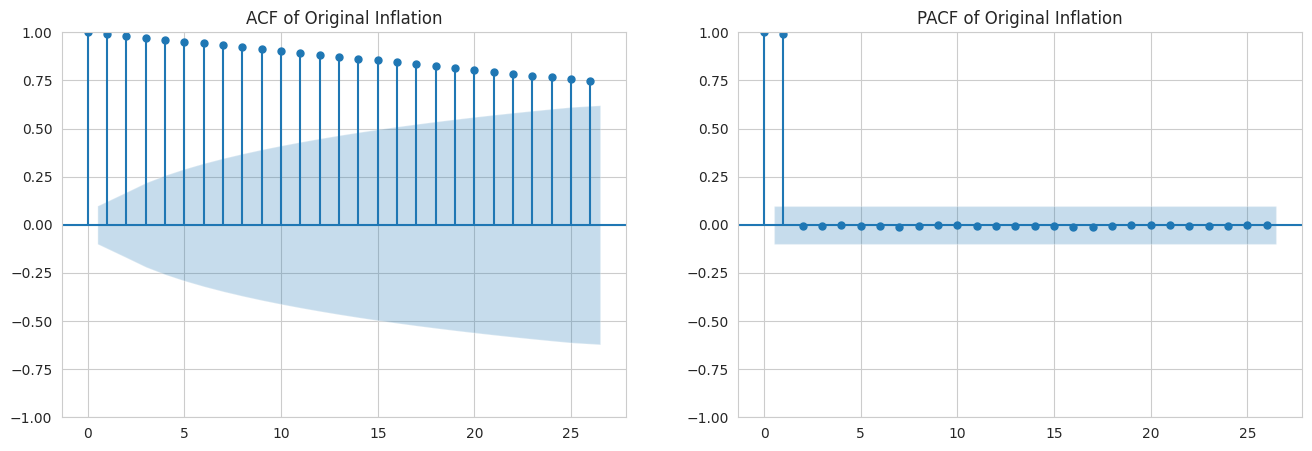


--- Autocorrelation of the Differenced (Stationary) Series ---


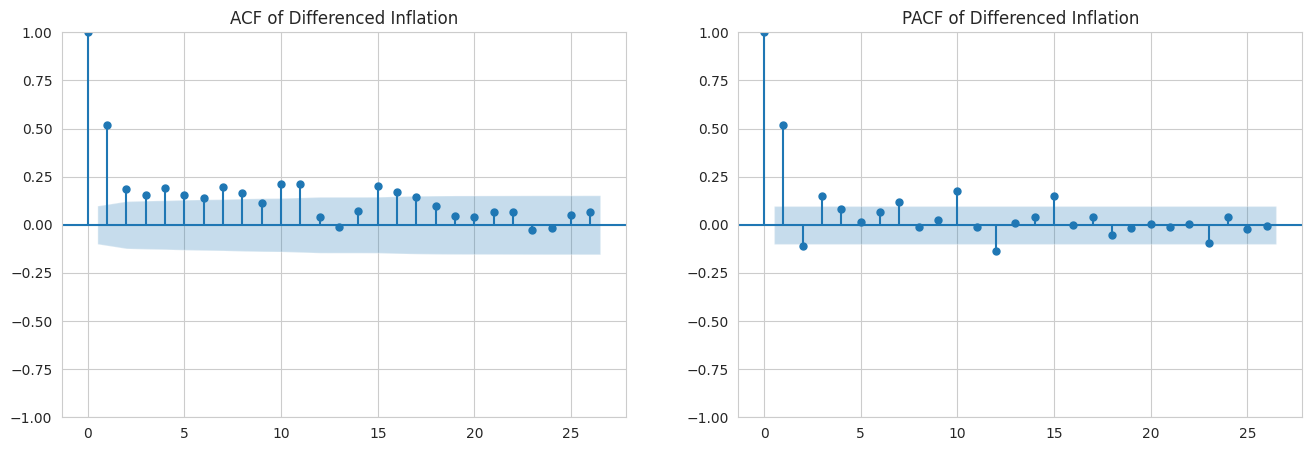

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print("--- Autocorrelation of the Original (Non-Stationary) Series ---")
#The ACF for a series with a strong trend will decay very slowly
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(clean_df['Inflation_CPI'], ax=ax[0], title='ACF of Original Inflation')
plot_pacf(clean_df['Inflation_CPI'], ax=ax[1], title='PACF of Original Inflation')
plt.show()

print("\n--- Autocorrelation of the Differenced (Stationary) Series ---")
#The ACF for a stationary series will drop off much more quickly
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(differenced_series, ax=ax[0], title='ACF of Differenced Inflation')
plot_pacf(differenced_series, ax=ax[1], title='PACF of Differenced Inflation')
plt.show()

##Analysis of Autocorrelation for Original Inflation

(These plots analyze the "memory" of the raw inflation data before we made it stationary)

##ACF Plot (Top Left):

The autocorrelation bars are very high and decay extremely slowly. This is the classic signature of a non-stationary series. It indicates that a high degree of the value at any given time is simply due to the strong underlying trend, meaning this month's value is almost identical to last month's value.

##PACF Plot (Top Right):

The partial autocorrelation plot shows a single, massive spike at Lag 1 and is insignificant everywhere else. This reinforces the non-stationary diagnosis. It tells us that after accounting for the previous month's value (t−1), there is no new information to be gained from any other past values (t−2,t−3, etc.). All the series' "memory" is contained in the very next step.

##Analysis of Autocorrelation for Differenced Inflation

(These plots show the memory structure of the inflation data after we made it stationary by differencing. The change is dramatic.)

##ACF Plot (Bottom Left):

The slow decay is completely gone. Instead, the ACF has a few significant spikes at early lags and then quickly cuts off into the insignificant range (the blue shaded area). This pattern is typical of a stationary time series. The remaining significant spikes give us clues about the underlying structure of the data now that the trend is gone.

##PACF Plot (Bottom Right):

The PACF also shows a clear structure with a few significant spikes that differ from the ACF.

**Key Takeaways:**

- We compared two techniques achieve stationarity: detrending and differencing. Differencing seems to be the better technique. It successfully transformed the trending inflation data into a stationary series that fluctuates around a stable mean of zero.

- Autocorrelation Confirms the Diagnosis: The Autocorrelation (ACF) plots provided statistical proof of our visual findings. The original inflation series showed a very slowly decaying ACF, which is a classic sign of non-stationarity.

- The differenced inflation series showed an ACF that cut off quickly, the classic sign of a stationary series. This confirms that differencing was the correct step to prepare the data for modeling.
